<a href="https://colab.research.google.com/github/rrajasek95/nlp-243-notebooks/blob/main/Section_06_Text_Classification_using_RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification using PyTorch

In [ ]:
import os
import spacy # Text preprocessing

# Pytrch
import torch
import torch.nn as nn # Neural Net Layers module
import torch.optim as optim # Optimizers module
import torch.nn.functional as F # Functions module - activations, utilities like padding
import numpy as np

from tqdm.auto import tqdm # Add progress bar

from torch.utils.data import DataLoader, Dataset # Preparing data in batches for pytorch training

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
import seaborn as sns

import math
from itertools import chain

# Gensim word embeddings
import gensim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## BBC News Dataset

The BBC News Dataset is a small collection of news articles from 5 different topics - business, entertainment, politics, tech, sports.

Therfore, this makes for a pretty decent dataset for article classification.

In [ ]:
!wget http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip
!unzip bbc-fulltext.zip


--2020-11-23 08:13:28--  http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip
Resolving mlg.ucd.ie (mlg.ucd.ie)... 137.43.93.132
Connecting to mlg.ucd.ie (mlg.ucd.ie)|137.43.93.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874078 (2.7M) [application/zip]
Saving to: ‘bbc-fulltext.zip’

bbc-fulltext.zip    100%[===================>]   2.74M  --.-KB/s    in 0.1s    

2020-11-23 08:13:28 (20.3 MB/s) - ‘bbc-fulltext.zip’ saved [2874078/2874078]

Archive:  bbc-fulltext.zip
   creating: bbc/
   creating: bbc/business/
  inflating: bbc/business/001.txt    
  inflating: bbc/business/002.txt    
  inflating: bbc/business/003.txt    
  inflating: bbc/business/004.txt    
  inflating: bbc/business/005.txt    
  inflating: bbc/business/006.txt    
  inflating: bbc/business/007.txt    
  inflating: bbc/business/008.txt    
  inflating: bbc/business/009.txt    
  inflating: bbc/business/010.txt    
  inflating: bbc/business/011.txt    
  inflating: bbc/business/012.txt   

In [ ]:
!cat bbc/business/001.txt

Ad sales boost Time Warner profit

Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.

The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.

Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL

### Download Word2Vec Wikipedia embeddings

In [ ]:
# !wget http://vectors.nlpl.eu/repository/20/4.zip
# The above Gigaword vectors require part-of-speech information. Think about how you'll use these
# in your model - this would work better than context-free word embeddings

!wget http://vectors.nlpl.eu/repository/20/6.zip

--2020-11-23 08:13:29--  http://vectors.nlpl.eu/repository/20/6.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.225
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.225|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 635351287 (606M) [application/zip]
Saving to: ‘6.zip’

6.zip               100%[===================>] 605.92M  97.2MB/s    in 7.0s    

2020-11-23 08:13:36 (86.6 MB/s) - ‘6.zip’ saved [635351287/635351287]



In [ ]:
# !unzip 4.zip gigaword
!unzip 6.zip -d wikipedia

Archive:  6.zip
  inflating: wikipedia/meta.json     
  inflating: wikipedia/model.bin     
  inflating: wikipedia/model.txt     
  inflating: wikipedia/README        


In [ ]:
word2vec_weights = gensim.models.KeyedVectors.load_word2vec_format("wikipedia/model.txt") # Load embeddings into Gensim class containing matrix

## Prepare dataset

In [ ]:
def load_bbc_dataset(dataset_path):

    data = []

    for topic in ['business', 'entertainment', 'politics', 'sport', 'tech']:

        topic_path = os.path.join(dataset_path, topic)
        for filename in os.listdir(topic_path):
            file_path = os.path.join(topic_path, filename)

            try:
                with open(file_path, 'r') as text_file:
                    text = text_file.read()

                data.append((text, topic)) # (X = article text, y = article topic)
            except UnicodeDecodeError:
                print("Failed to read:", file_path,"! Skipping")
    
    return data

In [ ]:
data = load_bbc_dataset('bbc')

Failed to read: bbc/sport/199.txt ! Skipping


In [ ]:
texts, labels = zip(*data)

In [ ]:
train_texts, valid_texts, train_labels, valid_labels = train_test_split(texts, labels, stratify=labels)

## Feature Builder Classes

In [ ]:
# We'll be using SkLearn's TfIdfVectorizer to construct our n-gram feature vectors

# We'll create our custom sequencer class for converting a text into a sequence of integers corresponding to our tokens
# Input : "Hello, my name is Rishi"
# Output: [4, 3, 2 5, 6 , 7 ] # 4: Hello, 3: ',', 2: 'my', ... , 7: 'Rishi'
# We want the indices to access the vectors for the given word
# 4 - Index of vector corresponding to the word 'Hello'

# Our word vectors:
# 0 (say) [-0.016457 0.005666 0.021893 0.036763 -0.099810 0.020892 -0.023565 0.061527 -0.064225 -0.127303 -0.029338 0.054085 -0.028404 -0.021510 -0.099026 -0.030219 -0.113324 0.159025 -0.006395 -0.012752 -0.043114 0.055606 0.008410 -0.057141 0.150728 0.022703 0.059621 0.036312 0.081985 -0.036570 -0.057276 -0.105478 -0.004486 -0.064055 -0.125824 -0.076262 0.066562 -0.185299 -0.004718 -0.106012 0.078044 -0.049623 -0.019707 0.024215 0.070698 0.128529 -0.036913 -0.000408 -0.053999 -0.000760 0.011069 -0.037236 0.038052 0.047209 -0.000934 0.014226 -0.101589 -0.021408 0.037043 0.028972 -0.048394 -0.048568 0.023561 0.050198 0.002572 0.029351 -0.097906 0.068975 0.066806 -0.002132 0.041009 -0.013165 -0.001345 0.027810 -0.056385 -0.024247 -0.029757 0.031317 -0.020337 0.054462 0.089233 -0.126477 0.026837 -0.037890 0.143336 0.012796 -0.030611 0.113524 0.080372 -0.006593 -0.039996 -0.002388 0.020406 -0.005260 0.013018 -0.004855 0.000909 0.024569 0.032159 0.085467 0.002894 -0.002156 0.075847 -0.027901 0.162719 -0.017862 -0.020725 -0.013756 0.032742 -0.107903 -0.020145 0.104665 -0.048859 0.127686 0.065073 0.025002 0.036685 -0.015755 0.096920 0.061627 -0.018842 -0.055340 0.040091 0.063783 0.040945 0.132622 0.036789 -0.045669 0.042439 0.057564 0.002319 0.078522 -0.043101 0.024797 0.029955 -0.063213 -0.066685 -0.057995 0.044187 0.013773 0.049962 0.011659 -0.073489 0.085285 -0.002402 0.082264 0.110752 -0.091364 -0.082374 0.020575 -0.089784 -0.034675 -0.023478 -0.012981 -0.075382 -0.087736 0.101732 -0.049771 0.073409 0.105999 -0.008192 0.051214 0.005423 0.003315 0.051006 -0.072713 0.098589 -0.044787 0.030751 0.029813 -0.005148 0.005983 -0.043757 -0.030320 0.013599 0.009227 -0.028190 0.031872 -0.056918 0.047188 0.086135 0.053166 -0.081615 0.071527 0.085285 -0.034258 -0.095423 0.090446 0.049369 0.025583 0.022480 0.019886 0.095464 -0.025733 -0.054728 -0.028570 0.022430 -0.012296 0.039433 0.041846 -0.052139 -0.056371 0.079290 0.080066 0.027186 0.012930 -0.018256 -0.016459 0.060026 -0.042765 -0.020518 0.006542 -0.100084 -0.047055 0.098878 0.008997 0.043938 0.044421 0.013212 0.014310 0.008998 0.045343 -0.001792 0.043302 -0.082872 -0.063939 0.019913 0.047750 -0.058111 0.019319 -0.109353 -0.050987 -0.003592 -0.028676 -0.043118 0.039557 0.036327 -0.032287 0.021005 0.018498 -0.017329 0.009347 -0.004317 0.013634 -0.087900 -0.049935 0.007746 -0.038557 0.016165 -0.001408 -0.021590 -0.021483 0.041102 0.034813 0.024639 -0.014953 0.034395 0.042431 -0.034290 0.113096 0.028386 0.012610 0.113622 0.099868 -0.047553 -0.055141 0.081419 0.060897 0.033517 0.070338 0.040594 0.008233 0.002827 -0.048878 -0.006415 0.004285 -0.038513 0.050271 -0.026621 -0.035559 0.085345 -0.006597 0.023721 -0.046521 -0.052554 -0.081140 -0.101331 -0.006354 0.060702 0.041869 0.001872 -0.029082 -0.040995 -0.042205 -0.024152 -0.061239 0.037529 -0.052604 0.073380 0.021318]
# 1 (year) [-0.020862 0.091081 0.030143 0.044928 -0.039632 -0.052762 0.086554 -0.033820 -0.039126 -0.049076 0.019706 -0.016391 0.039894 0.070685 -0.009264 0.013761 -0.014918 -0.005033 -0.026868 0.139029 -0.092375 0.072021 0.086156 0.060858 0.022265 0.070539 -0.000366 -0.077498 0.074328 0.018448 -0.133731 -0.070511 -0.007111 -0.090394 -0.002611 -0.077230 0.020074 0.065541 0.003582 -0.071871 0.076368 -0.007130 0.053619 0.000117 -0.002221 0.011619 -0.099297 -0.032122 -0.021738 -0.005857 0.035957 -0.015488 -0.054147 0.045498 -0.023322 -0.028272 -0.012185 -0.088205 0.069354 0.032746 0.047092 -0.083746 -0.030912 0.061607 0.102859 -0.011405 -0.007592 -0.013440 0.083539 0.028081 -0.004936 0.017838 0.070643 -0.039028 -0.017780 -0.090181 -0.076588 -0.001165 0.036132 -0.102343 0.106976 0.015121 0.054096 -0.043179 -0.042845 -0.013959 -0.044288 0.061936 -0.042800 0.049818 -0.005679 -0.040999 0.007476 0.041139 -0.020163 -0.072105 0.067300 -0.024149 0.047047 -0.012251 0.021856 -0.230840 -0.069708 -0.128597 0.046794 0.003120 -0.098918 0.038630 0.015836 0.041364 0.004654 0.030140 -0.026638 -0.040064 -0.004387 0.033325 -0.028964 0.063713 0.082938 0.047717 -0.028720 -0.000124 -0.058471 0.054698 -0.077716 0.014115 0.045998 -0.039880 0.037951 -0.022623 -0.073551 -0.029734 -0.006686 -0.046788 -0.047048 0.048809 0.065685 -0.094081 0.009960 0.040303 0.109173 -0.079072 -0.038558 0.043107 -0.046333 -0.051847 -0.055877 0.035927 -0.000557 -0.028910 -0.001796 0.009779 0.070724 -0.076734 -0.049698 -0.051177 -0.010030 -0.032417 0.112298 -0.048902 -0.110678 0.024402 -0.093728 0.013824 0.027871 -0.020682 -0.000717 0.087400 0.072489 -0.054522 -0.016094 -0.073715 -0.037509 0.001349 -0.107182 0.002886 -0.007559 -0.038211 0.006419 -0.116266 0.035283 -0.045140 0.036843 0.087636 -0.004077 0.071094 0.029225 0.058551 0.066372 0.092901 0.043376 -0.007894 0.005130 -0.070292 -0.052419 -0.028484 0.089438 -0.008769 -0.055218 0.019262 0.033993 0.008990 0.143733 -0.010378 0.078207 -0.031403 0.004595 -0.095942 -0.056159 0.050025 -0.027929 -0.024954 -0.114869 -0.073308 0.035274 -0.097693 -0.029095 -0.020764 -0.005055 0.009123 0.021029 -0.123420 0.029189 -0.003864 0.081216 0.044239 -0.149860 -0.049339 0.064162 0.108673 0.028682 -0.057684 0.019785 -0.004504 -0.115881 0.052063 0.119204 0.009445 -0.049341 -0.054128 0.065719 -0.006246 0.065020 0.005824 -0.094724 -0.091890 0.064122 -0.080926 0.031800 -0.029981 0.018315 -0.034446 0.021722 0.071480 -0.060150 -0.064157 0.015135 -0.054347 -0.010469 0.031822 0.011353 -0.066325 -0.103637 -0.053428 0.021063 -0.063239 -0.027001 0.004307 -0.055074 -0.036124 -0.058356 -0.004795 0.007763 -0.019251 0.068137 -0.048656 -0.087174 -0.046017 -0.067088 -0.023913 0.057596 0.070647 0.042291 0.029272 -0.065840 -0.045579 -0.084960 -0.014945 0.117556 -0.029472 0.023953 0.036586 0.027706 -0.081025 -0.004470 -0.034535 0.033065 -0.054836 -0.043534 -0.055042]
# 314814 (wn) [-0.020862 0.091081 0.030143 0.044928 -0.039632 -0.052762 0.086554 -0.033820 -0.039126 -0.049076 0.019706 -0.016391 0.039894 0.070685 -0.009264 0.013761 -0.014918 -0.005033 -0.026868 0.139029 -0.092375 0.072021 0.086156 0.060858 0.022265 0.070539 -0.000366 -0.077498 0.074328 0.018448 -0.133731 -0.070511 -0.007111 -0.090394 -0.002611 -0.077230 0.020074 0.065541 0.003582 -0.071871 0.076368 -0.007130 0.053619 0.000117 -0.002221 0.011619 -0.099297 -0.032122 -0.021738 -0.005857 0.035957 -0.015488 -0.054147 0.045498 -0.023322 -0.028272 -0.012185 -0.088205 0.069354 0.032746 0.047092 -0.083746 -0.030912 0.061607 0.102859 -0.011405 -0.007592 -0.013440 0.083539 0.028081 -0.004936 0.017838 0.070643 -0.039028 -0.017780 -0.090181 -0.076588 -0.001165 0.036132 -0.102343 0.106976 0.015121 0.054096 -0.043179 -0.042845 -0.013959 -0.044288 0.061936 -0.042800 0.049818 -0.005679 -0.040999 0.007476 0.041139 -0.020163 -0.072105 0.067300 -0.024149 0.047047 -0.012251 0.021856 -0.230840 -0.069708 -0.128597 0.046794 0.003120 -0.098918 0.038630 0.015836 0.041364 0.004654 0.030140 -0.026638 -0.040064 -0.004387 0.033325 -0.028964 0.063713 0.082938 0.047717 -0.028720 -0.000124 -0.058471 0.054698 -0.077716 0.014115 0.045998 -0.039880 0.037951 -0.022623 -0.073551 -0.029734 -0.006686 -0.046788 -0.047048 0.048809 0.065685 -0.094081 0.009960 0.040303 0.109173 -0.079072 -0.038558 0.043107 -0.046333 -0.051847 -0.055877 0.035927 -0.000557 -0.028910 -0.001796 0.009779 0.070724 -0.076734 -0.049698 -0.051177 -0.010030 -0.032417 0.112298 -0.048902 -0.110678 0.024402 -0.093728 0.013824 0.027871 -0.020682 -0.000717 0.087400 0.072489 -0.054522 -0.016094 -0.073715 -0.037509 0.001349 -0.107182 0.002886 -0.007559 -0.038211 0.006419 -0.116266 0.035283 -0.045140 0.036843 0.087636 -0.004077 0.071094 0.029225 0.058551 0.066372 0.092901 0.043376 -0.007894 0.005130 -0.070292 -0.052419 -0.028484 0.089438 -0.008769 -0.055218 0.019262 0.033993 0.008990 0.143733 -0.010378 0.078207 -0.031403 0.004595 -0.095942 -0.056159 0.050025 -0.027929 -0.024954 -0.114869 -0.073308 0.035274 -0.097693 -0.029095 -0.020764 -0.005055 0.009123 0.021029 -0.123420 0.029189 -0.003864 0.081216 0.044239 -0.149860 -0.049339 0.064162 0.108673 0.028682 -0.057684 0.019785 -0.004504 -0.115881 0.052063 0.119204 0.009445 -0.049341 -0.054128 0.065719 -0.006246 0.065020 0.005824 -0.094724 -0.091890 0.064122 -0.080926 0.031800 -0.029981 0.018315 -0.034446 0.021722 0.071480 -0.060150 -0.064157 0.015135 -0.054347 -0.010469 0.031822 0.011353 -0.066325 -0.103637 -0.053428 0.021063 -0.063239 -0.027001 0.004307 -0.055074 -0.036124 -0.058356 -0.004795 0.007763 -0.019251 0.068137 -0.048656 -0.087174 -0.046017 -0.067088 -0.023913 0.057596 0.070647 0.042291 0.029272 -0.065840 -0.045579 -0.084960 -0.014945 0.117556 -0.029472 0.023953 0.036586 0.027706 -0.081025 -0.004470 -0.034535 0.033065 -0.054836 -0.043534 -0.055042]
# VOCAB_SIZE x 300 Matrix

class Sequencer(object):
    def __init__(self, corpus, bos_token='<s>', eos_token='</s>', unk_token='<unk>', pad_token='<pad>'):
        self.word2idx = {}
        self.idx2word = {}

        self.unk_index = self.add_token(unk_token) 
        self.pad_index = self.add_token(pad_token)
        self.bos_index = self.add_token(bos_token)
        self.eos_index = self.add_token(eos_token)
        self.nlp = spacy.load('en')
        self.tokenizer = lambda text: [t.text for t in self.nlp(text)]

    def add_token(self, token):

        self.word2idx[token] = new_index = len(self.word2idx)
        self.idx2word[new_index] = token

        return new_index

    def encode(self, text):
        # Input will look like:
        # [<s>, w1, w2, ..., wn, </s>]
        tokens = self.tokenizer(text)

        sequence = [self.bos_index]
        for token in tokens:

            index = self.word2idx.get(token, self.unk_index)
            sequence.append(index)
        sequence.append(self.eos_index)

        return sequence

    def create_padded_tensor_with_lengths(self, sequences):
        # Input: [[4, 2, 3], [5, 4, 2, 4, 6]]
        # Output:
        # Tensor
        # 4 2 3 0 0
        # 5 4 2 4 6

        # Given a list of sequences, pad all to the same length
        lengths = [len(sequence) for sequence in sequences]
        max_seq_len = max(lengths)
        tensor = torch.full((len(sequences), max_seq_len), self.pad_index, dtype=torch.long)

        for i, sequence in enumerate(sequences):
            for j, token in enumerate(sequence):
                tensor[i][j] = token
        
        return tensor, lengths

class W2VSequencer(object):
    def __init__(self, gensim_w2v):
        # Performs the same thing as the previous class
        # Except it uses the vocabulary of words from the word embeddings we use

        self.nlp = spacy.load('en')
        self.w2v = gensim_w2v
        self.w2v.add(['<unk>'], [np.random.uniform(low=-1, high=1.0, size=(300,))])

        self.unk_index = self.w2v.vocab.get('<unk>')
        self.tokenizer = lambda text: [t.text for t in self.nlp(text)]

    def encode(self, text):
        # Input will look like:
        # [<s>, w1, w2, ..., wn, </s>]
        sequence = []
        tokens = self.tokenizer(text)
        for token in tokens:

            index = self.w2v.vocab.get(token, self.unk_index).index
            sequence.append(index)

        return sequence

    def create_padded_tensor_with_lengths(self, sequences):
        # Given a list of sequences, pad all to the same length

        lengths = [len(sequence) for sequence in sequences]
        max_seq_len = max(lengths)
        tensor = torch.full((len(sequences), max_seq_len), 0, dtype=torch.long)

        for i, sequence in enumerate(sequences):
            for j, token in enumerate(sequence):
                tensor[i][j] = token
        
        return tensor, lengths

# For converting labels into indices 0 - L1, 1 - L2
class LabelIndexer(object):
    def __init__(self, labels):
        self.label2idx = {label: i for i, label in enumerate(labels)}
        self.idx2label = {i:label for label, i in self.label2idx.items()}
        self.labels = labels

    def encode(self, y):
        return self.label2idx[y]

    def encode_batch(self, ys):
        return torch.LongTensor([self.encode(y) for y in ys])


## Dataset class

In [ ]:
class BBCNewsDataset(Dataset):
    # This class is an interface for our training/test dataset
    # with pytorch

    # It prepares our training/test examples into a form that pytorch expects
    # Input: ["Warner Bros gets $1m profit ", "business"]
    # Output: [[TFIDF/Word Vector for text, 0]]
    def __init__(self, texts, labels, input_transformer, output_transformer):
        self.texts = texts
        self.labels = labels
        self.input_transformer = input_transformer
        self.output_transformer = output_transformer

    def __getitem__(self, index): # Return a single example
    
        text = self.texts[index]
        label = self.labels[index]

        x = self.input_transformer(text) # Produces TF-IDF/List of indices from text
        y = self.output_transformer(label) # Produces index from the label text i.e. "business" to 0
        
        return x, y

    def __len__(self):
        return len(self.texts)

## Model classes

In [ ]:
class SimpleLSTMClassifier(nn.Module):
    """
    This model comprises a simple LSTM whose final hidden state is used
    to output a prediction
    """

    def __init__(self, output_size, n_layers=2, rnn_hidden_size=50, dropout_p=0.1, bidirectional=True, w2v_weights=None):
        super(SimpleLSTMClassifier, self).__init__()

        # Embedding: takes an integer index representing the word, and returns the corresponding vector for that word
        self.embedding = nn.Embedding.from_pretrained(w2v_weights)
        # self.embedding = nn.Embedding(vocab_size, embedding_dim) - nn.Embedding(314815, 300)
        embed_dim = 300

        n_directions = (2 if bidirectional else 1)

        self.frozen_embedding = nn.Embedding.from_pretrained(w2v_weights)
        self.frozen_embedding.requires_grad = False # Disable gradient updates, freezes the parameters from updates during training

        # self.add_dropout = dropout
        # self.dropout = nn.Dropout(dropout_p)

        self.rnn = nn.LSTM(
            input_size=2*embed_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            hidden_size=rnn_hidden_size, 
            bias=True, 
            dropout=dropout_p,
            batch_first=True
            )
        
        linear_input = n_layers * (2 if bidirectional else 1) * rnn_hidden_size

        self.fc = nn.Linear(linear_input, output_size)



    def forward(self, x, lengths):
        # x size: [batch_size, seq_len]
        # After embedding: [batch_size, seq_len, emb_dim = 300] # 16 * 100 * 300 
        # After transposing it: [batch_size, emb_dim, seq_len]
        batch_size = x.size(0)
        embed = self.embedding(x)
        embed_frozen = self.frozen_embedding(x)

        # embed/embed_frozen shape: [batch_size, seq_len, embed_dim]

        combined_embedding = torch.cat((embed, embed_frozen), dim=-1)
        # combined_embedding shape: [batch_size, seq_len, 2*embed_dim]
        packed_input = nn.utils.rnn.pack_padded_sequence(combined_embedding, lengths, batch_first=True, enforce_sorted=False)
        # packed_input (PackedTensor)

        output, (h_n, c_n) = self.rnn(packed_input)

        # output: [batch_size, seq_len, hidden_size]
        #  h_n: [batch_size, n_layers * n_directions, hidden_size]


        # last_indices = torch.tensor(lengths, device=device) - 1

        # h_squeezed = h_n.squeeze(0)
        

        # last_hiddens = output[torch.arange(batch_size), last_indices]
        logits = self.fc(h_n.view(batch_size, -1))
        # logits = self.fc(last_hiddens)

        return logits

## Trainer Class

In [ ]:
class MultiClassTrainer(object):
    """
    Trainer for training a multi-class classification model
    """

    def __init__(self, model, optimizer, loss_fn, device="cpu", log_every_n=None):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.device = device
        self.loss_fn = loss_fn
        
        self.log_every_n = log_every_n if log_every_n else 0


    def _print_summary(self):
        print(self.model)
        print(self.optimizer)
        print(self.loss_fn)

    def train(self, loader):
        """
        Run a single epoch of training
        """

        self.model.train() # Run model in training mode

        loss_history = []
        running_loss = 0.
        running_loss_history = []

        for i, batch in tqdm(enumerate(loader)):
            batch_size = batch[0].shape[0]
            self.optimizer.zero_grad() # Always set gradient to 0 before computing it

            logits = self.model(batch[0].to(self.device), batch[1]) # __call__ model() in this case: __call__ internally calls forward()
            # [batch_size, num_classes]

            loss = self.loss_fn(logits, batch[2].view(-1).to(self.device)) # Compute loss: Cross entropy loss

            loss_history.append(loss.item())

            

            running_loss += (loss_history[-1] - running_loss) / (i + 1) # Compute rolling average

            loss.backward() # Perform backprop, which will compute dL/dw

            if self.log_every_n and i % self.log_every_n == 0:
                print("Running loss: ", running_loss)

                # print("Gradients:")
                # for p in list(filter(lambda p: p.grad is not None, self.model.parameters())):
                #     print(p.grad.data.norm(2).item())

            running_loss_history.append(running_loss)
            
            nn.utils.clip_grad_norm_(self.model.parameters(), 3.0) # We clip gradient's norm to 3

            self.optimizer.step() # Update step: w = w - eta * dL / dW : eta = 1e-2 (0.01), gradient = 5e30; update value of 5e28

        print("Epoch completed!")
        print("Epoch Loss: ", running_loss)
        print("Epoch Perplexity: ", math.exp(running_loss))

        # The history information can allow us to draw a loss plot
        return loss_history, running_loss_history

    def evaluate(self, loader, labels):
        """
        Evaluate the model on a validation set
        """

        self.model.eval() # Run model in eval mode (disables dropout layer)

        batch_wise_true_labels = []
        batch_wise_predictions = []

        loss_history = []
        running_loss = 0.
        running_loss_history = []

        with torch.no_grad(): # Disable gradient computation - required only during training
            for i, batch in tqdm(enumerate(loader)):
                # batch[0] shape: (batch_size, input_size)

                logits = self.model(batch[0].to(self.device), batch[1]) # Run forward pass (except we don't store gradients)
                # logits shape: (batch_size, num_classes)
                
                loss = self.loss_fn(logits, batch[2].view(-1).to(self.device)) # Compute loss
                # No backprop is done during validation
                
                # Instead of using CrossEntropyLoss, you use BCEWithLogitsLoss
                # BCEWithLogitsLoss - independently calculates loss for each class
                

                loss_history.append(loss.item())

                running_loss += (loss_history[-1] - running_loss) / (i + 1) # Compute rolling average
                
                running_loss_history.append(running_loss)

                # logits : [batch_size, num_classes] and each of the values in logits can be anything (-infinity, +infity)
                # Converts the raw outputs into probabilities for each class using softmax
                probs = F.softmax(logits, dim=-1) 
                # probs shape: (batch_size, num_classes)
                # -1 dimension picks the last dimension in the shape of the tensor, in this case 'num_classes'
                

                # softmax vector: [[0.1, 0.2, 0.6, 0.1, 0.0], [0.9, 0.01, 0.01, 0.01, 0.07]]
                # output tensor: [2, 0]
                predictions = torch.argmax(probs, dim=-1) # Output predictions; Argmax picks the index with the highest probability among all the classes (choosing our most probable class)
                # predictions shape: (batch_size)

                batch_wise_true_labels.append(batch[2].tolist())
                batch_wise_predictions.append(predictions.tolist())
        
        # flatten the list of predictions using itertools
        all_true_labels = list(chain.from_iterable(batch_wise_true_labels))
        all_predictions = list(chain.from_iterable(batch_wise_predictions))

        # Now we can generate a classification report
        print("Classification report after epoch:")
        print(classification_report(all_true_labels, all_predictions, target_names=labels))

        return loss_history, running_loss_history

    def get_model_dict(self):
        return self.model.state_dict()

    def run_training(self, train_loader, valid_loader, labels, n_epochs=10):
        # Useful for us to review what experiment we're running
        # Normally, you'd want to save this to a file
        self._print_summary()

        train_losses = []
        train_running_losses = []

        valid_losses = []
        valid_running_losses = []

        for i in range(n_epochs):
            loss_history, running_loss_history = self.train(train_loader)
            valid_loss_history, valid_running_loss_history = self.evaluate(valid_loader, labels)

            train_losses.append(loss_history)
            train_running_losses.append(running_loss_history)

            valid_losses.append(valid_loss_history)
            valid_running_losses.append(valid_running_loss_history)

        # Training done, let's look at the loss curves
        all_train_losses = list(chain.from_iterable(train_losses))
        all_train_running_losses = list(chain.from_iterable(train_running_losses))

        all_valid_losses = list(chain.from_iterable(valid_losses))
        all_valid_running_losses = list(chain.from_iterable(valid_running_losses))

        train_epoch_idx = range(len(all_train_losses))
        valid_epoch_idx = range(len(all_valid_losses))
        # sns.lineplot(epoch_idx, all_losses)
        sns.lineplot(train_epoch_idx, all_train_running_losses)
        sns.lineplot(valid_epoch_idx, all_valid_running_losses)
        plt.show()

## Data Preparation

In [ ]:
sequencer = W2VSequencer(word2vec_weights)
sequence_input_transformer = lambda text: sequencer.encode(text)

label_indexer = LabelIndexer(list(set(labels)))
output_transformer = lambda label: torch.LongTensor([label_indexer.encode(label)])

def prepare_batch(batch, sequencer):
    # batch: [batch_len, (text, label)]
    texts, labels = zip(*batch)
    text_tensor, lengths = sequencer.create_padded_tensor_with_lengths(texts)
    return (text_tensor, lengths, torch.stack(labels))

train_sequence_dataset = BBCNewsDataset(train_texts, train_labels, sequence_input_transformer, output_transformer)
valid_sequence_dataset = BBCNewsDataset(valid_texts, valid_labels, sequence_input_transformer, output_transformer)

train_sequence_loader = torch.utils.data.DataLoader(train_sequence_dataset, batch_size=4, collate_fn=lambda batch: prepare_batch(batch, sequencer))
valid_sequence_loader = torch.utils.data.DataLoader(valid_sequence_dataset, batch_size=4, collate_fn=lambda batch: prepare_batch(batch, sequencer))

## Running Training

In [ ]:
hidden_size = 64
output_size = len(label_indexer.label2idx) #

print(output_size)

# Our experimental hyperparameters
LEARNING_RATE = 1e-3

loss_fn = nn.CrossEntropyLoss() # L = - sum (y_i log (y^i_hat))

5


### LSTM Classifier

SimpleLSTMClassifier(
  (embedding): Embedding(302867, 300)
  (frozen_embedding): Embedding(302867, 300)
  (rnn): LSTM(600, 64, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.001
)
CrossEntropyLoss()


Running loss:  1.6516753435134888
Running loss:  1.6018275997855447
Running loss:  1.6264535358973913
Running loss:  1.6455403181814376
Running loss:  1.6359264210956852
Running loss:  1.6238497893015542
Running loss:  1.6257728299156566
Running loss:  1.6254380404109687
Running loss:  1.6240046671879145
Running loss:  1.619886256836273
Running loss:  1.6203035541100077
Running loss:  1.620503346125285
Running loss:  1.617679329943066
Running loss:  1.61631573338545
Running loss:  1.6174319788073814
Running loss:  1.6177814180487824
Running loss:  1.6178375771327043
Running loss:  1.6173052773838148
Running loss:  1.616197757958048
Running loss:  1.6161006039973946
Running loss:  1.6155989804671174
Running loss:  1.614219626544211
Running loss:  1.6137257010688606
Running loss:  1.6130440348670592
Running loss:  1.6123789969321596
Running loss:  1.6112400806282614
Running loss:  1.6108812810817432
Running loss:  1.6106124900803784
Running loss:  1.6095082072600762
Running loss:  1.6083


Classification report after epoch:
               precision    recall  f1-score   support

entertainment       0.40      0.02      0.04        97
     business       0.33      0.18      0.23       128
         tech       0.14      0.19      0.16       100
        sport       0.28      0.35      0.31       127
     politics       0.23      0.40      0.29       104

     accuracy                           0.23       556
    macro avg       0.27      0.23      0.21       556
 weighted avg       0.28      0.23      0.21       556



Running loss:  1.5745508670806885
Running loss:  1.5722976922988892
Running loss:  1.5951720419384183
Running loss:  1.5952335096174668
Running loss:  1.5907350982107766
Running loss:  1.580834061491723
Running loss:  1.5797086700064233
Running loss:  1.5801869378962985
Running loss:  1.5816460965592183
Running loss:  1.5762596628168126
Running loss:  1.576475947210104
Running loss:  1.575911974047755
Running loss:  1.5713797669765375
Running loss:  1.5644091977417927
Running loss:  1.5626144324634095
Running loss:  1.563261879990433
Running loss:  1.5585962896761694
Running loss:  1.553719752016124
Running loss:  1.5469173357631627
Running loss:  1.551327992484208
Running loss:  1.554101506275918
Running loss:  1.5535577179696332
Running loss:  1.5552161344036266
Running loss:  1.5558864069191418
Running loss:  1.5559999918047331
Running loss:  1.5548223651262874
Running loss:  1.552747601750254
Running loss:  1.5511828986481113
Running loss:  1.5488048804612353
Running loss:  1.54615


Classification report after epoch:
               precision    recall  f1-score   support

entertainment       0.75      0.03      0.06        97
     business       0.24      0.15      0.18       128
         tech       0.44      0.11      0.18       100
        sport       0.31      0.95      0.47       127
     politics       0.21      0.12      0.15       104

     accuracy                           0.30       556
    macro avg       0.39      0.27      0.21       556
 weighted avg       0.38      0.30      0.22       556



Running loss:  1.4783308506011963
Running loss:  1.3528040647506714
Running loss:  1.3696528502873009
Running loss:  1.456869356093868
Running loss:  1.4430059805148985
Running loss:  1.4220244463752298
Running loss:  1.4173019831297828
Running loss:  1.401119354745032
Running loss:  1.393292299023381
Running loss:  1.382374217222025
Running loss:  1.3721171039165836
Running loss:  1.3751815836708823
Running loss:  1.374605574883705
Running loss:  1.3722869212390807
Running loss:  1.368306717128618
Running loss:  1.360904769392203
Running loss:  1.3517312396387133
Running loss:  1.341802008319319
Running loss:  1.339619040818504
Running loss:  1.3460689873595513
Running loss:  1.3420657052922604
Running loss:  1.3454560549903254
Running loss:  1.3561984074061812
Running loss:  1.3618366754416262
Running loss:  1.356249879751957
Running loss:  1.3494661379145432
Running loss:  1.3468711903725545
Running loss:  1.3512575382236183
Running loss:  1.348144977754545
Running loss:  1.34300934


Classification report after epoch:
               precision    recall  f1-score   support

entertainment       0.52      0.49      0.51        97
     business       0.40      0.25      0.31       128
         tech       0.56      0.27      0.36       100
        sport       0.61      0.61      0.61       127
     politics       0.33      0.65      0.44       104

     accuracy                           0.46       556
    macro avg       0.48      0.46      0.45       556
 weighted avg       0.48      0.46      0.45       556



Running loss:  1.2834938764572144
Running loss:  1.2211281494660813
Running loss:  1.2152669827143354
Running loss:  1.239990686216662
Running loss:  1.212443569811379
Running loss:  1.189439074665892
Running loss:  1.2168956350107658
Running loss:  1.1940955662391557
Running loss:  1.1894252844798716
Running loss:  1.1896242348702406
Running loss:  1.1787876539891315
Running loss:  1.1745066218548
Running loss:  1.1750116929535044
Running loss:  1.1727318640883646
Running loss:  1.1605852673239745
Running loss:  1.1487271394950667
Running loss:  1.1408825772149225
Running loss:  1.1331524838481033
Running loss:  1.1335628678126888
Running loss:  1.1364016482967356
Running loss:  1.1360217344701586
Running loss:  1.1358890688814822
Running loss:  1.1301437144365785
Running loss:  1.1266381554789355
Running loss:  1.1192438629652945
Running loss:  1.1143520246463936
Running loss:  1.109330652317324
Running loss:  1.1218030355953192
Running loss:  1.1179889932646014
Running loss:  1.1110


Classification report after epoch:
               precision    recall  f1-score   support

entertainment       0.67      0.47      0.55        97
     business       0.52      0.45      0.48       128
         tech       0.54      0.51      0.53       100
        sport       0.80      0.91      0.85       127
     politics       0.50      0.67      0.57       104

     accuracy                           0.61       556
    macro avg       0.61      0.60      0.60       556
 weighted avg       0.61      0.61      0.60       556



Running loss:  0.9262908101081848
Running loss:  0.8340239362283187
Running loss:  0.8829423927125476
Running loss:  0.9090325928503468
Running loss:  0.8937361894584284
Running loss:  0.877964181058547
Running loss:  0.9352041668579226
Running loss:  0.9386974589925416
Running loss:  0.9263832407233157
Running loss:  0.9156136735455022
Running loss:  0.9083983340475819
Running loss:  0.8994883545884141
Running loss:  0.9010564586347785
Running loss:  0.9092316258954637
Running loss:  0.9127081087295045
Running loss:  0.9113808226901173
Running loss:  0.9117147904005108
Running loss:  0.9159105019262659
Running loss:  0.9123099382081741
Running loss:  0.9048976937201632
Running loss:  0.9086885023769451
Running loss:  0.9080847648647722
Running loss:  0.9119034143864297
Running loss:  0.9095887939135232
Running loss:  0.9092353173063996
Running loss:  0.9012800135697975
Running loss:  0.9014882506995364
Running loss:  0.8998250387251595
Running loss:  0.8949355229576287
Running loss:  


Classification report after epoch:
               precision    recall  f1-score   support

entertainment       0.65      0.57      0.60        97
     business       0.49      0.65      0.56       128
         tech       0.53      0.43      0.48       100
        sport       0.95      0.94      0.94       127
     politics       0.56      0.52      0.54       104

     accuracy                           0.64       556
    macro avg       0.64      0.62      0.62       556
 weighted avg       0.64      0.64      0.64       556



Running loss:  0.7451841831207275
Running loss:  0.6680730405178937
Running loss:  0.6783777283770698
Running loss:  0.7317835981807401
Running loss:  0.7168041180546689
Running loss:  0.6674302795938417
Running loss:  0.7432631481377804
Running loss:  0.764978756157445
Running loss:  0.7531421598460937
Running loss:  0.7485889682730471
Running loss:  0.7718382057281999
Running loss:  0.7765038624271614
Running loss:  0.7743512917894961
Running loss:  0.7845189147095643
Running loss:  0.7876484526175979
Running loss:  0.772420395387719
Running loss:  0.7610940943408456
Running loss:  0.76934994861745
Running loss:  0.7613777805593132
Running loss:  0.7552475675706461
Running loss:  0.7592526935967638
Running loss:  0.7566752365273886
Running loss:  0.7536751462728188
Running loss:  0.7472229230326491
Running loss:  0.7466061490576296
Running loss:  0.7394537657380577
Running loss:  0.7567442862238464
Running loss:  0.7623929253803409
Running loss:  0.7613550973956696
Running loss:  0.7


Classification report after epoch:
               precision    recall  f1-score   support

entertainment       0.65      0.48      0.56        97
     business       0.58      0.49      0.53       128
         tech       0.56      0.62      0.59       100
        sport       0.95      0.96      0.95       127
     politics       0.50      0.65      0.56       104

     accuracy                           0.65       556
    macro avg       0.65      0.64      0.64       556
 weighted avg       0.66      0.65      0.65       556



Running loss:  0.5289764404296875
Running loss:  0.6509194360537963
Running loss:  0.679984817192668
Running loss:  0.7699954629905762
Running loss:  0.7333841476498582
Running loss:  0.7051858419881147
Running loss:  0.7866939220760689
Running loss:  0.7746782271375119
Running loss:  0.7609798597332872
Running loss:  0.7682183956379418
Running loss:  0.7635545162576259
Running loss:  0.7570889735812539
Running loss:  0.7507425939494915
Running loss:  0.7638489484559491
Running loss:  0.7614655297064614
Running loss:  0.7477683722972872
Running loss:  0.7354257804636632
Running loss:  0.7410588426548141
Running loss:  0.7347150309968393
Running loss:  0.7279866397068766
Running loss:  0.7284615592873515
Running loss:  0.7284638520100671
Running loss:  0.7267182246861955
Running loss:  0.7206547322211327
Running loss:  0.717845870869783
Running loss:  0.708914715455348
Running loss:  0.718275091771422
Running loss:  0.7214483523060917
Running loss:  0.7169235395367038
Running loss:  0.7


Classification report after epoch:
               precision    recall  f1-score   support

entertainment       0.64      0.65      0.64        97
     business       0.67      0.52      0.58       128
         tech       0.46      0.60      0.52       100
        sport       1.00      0.97      0.98       127
     politics       0.55      0.56      0.55       104

     accuracy                           0.67       556
    macro avg       0.66      0.66      0.66       556
 weighted avg       0.68      0.67      0.67       556



Running loss:  0.6616272926330566
Running loss:  0.532649340954694
Running loss:  0.6062192987828029
Running loss:  0.6657092302076278
Running loss:  0.6298245853040276
Running loss:  0.5952528358674516
Running loss:  0.6490900946445152
Running loss:  0.6436226258815172
Running loss:  0.6331734219451006
Running loss:  0.6292094288619008
Running loss:  0.6321823353519533
Running loss:  0.6474236683534071
Running loss:  0.6511657832821536
Running loss:  0.66286509671739
Running loss:  0.6642295674863434
Running loss:  0.6574794812905078
Running loss:  0.6451355285526063
Running loss:  0.6424714656252611
Running loss:  0.6537120123265199
Running loss:  0.6446033399454587
Running loss:  0.645113386695658
Running loss:  0.6399534118683984
Running loss:  0.6321824234130696
Running loss:  0.6319651140537098
Running loss:  0.6293510195501613
Running loss:  0.6302170703313741
Running loss:  0.6344825786135206
Running loss:  0.6373754055462639
Running loss:  0.631929018398833
Running loss:  0.62


Classification report after epoch:
               precision    recall  f1-score   support

entertainment       0.69      0.68      0.69        97
     business       0.79      0.36      0.49       128
         tech       0.53      0.71      0.60       100
        sport       0.93      0.99      0.96       127
     politics       0.64      0.82      0.72       104

     accuracy                           0.71       556
    macro avg       0.72      0.71      0.69       556
 weighted avg       0.73      0.71      0.70       556



Running loss:  0.47517693042755127
Running loss:  0.4136228832331571
Running loss:  0.47285678840818857
Running loss:  0.5852294141246425
Running loss:  0.552285709759084
Running loss:  0.538996152725874
Running loss:  0.5810231275734352
Running loss:  0.5704600891282018
Running loss:  0.5536516169431032
Running loss:  0.554603893555455
Running loss:  0.5690951927537374
Running loss:  0.5761678244683657
Running loss:  0.5754003629765726
Running loss:  0.5876031351055352
Running loss:  0.5868700158564334
Running loss:  0.5723266377304957
Running loss:  0.5648244142023302
Running loss:  0.5639348680382235
Running loss:  0.5640560913192961
Running loss:  0.5605998962376441
Running loss:  0.5769349947682955
Running loss:  0.5751614279833166
Running loss:  0.5735735294337454
Running loss:  0.568834527859311
Running loss:  0.5752825245910412
Running loss:  0.5701266189821924
Running loss:  0.5753862236508691
Running loss:  0.5770112427700709
Running loss:  0.5744793360847382
Running loss:  0


Classification report after epoch:
               precision    recall  f1-score   support

entertainment       0.81      0.81      0.81        97
     business       0.74      0.59      0.66       128
         tech       0.75      0.68      0.71       100
        sport       0.91      1.00      0.95       127
     politics       0.68      0.81      0.74       104

     accuracy                           0.78       556
    macro avg       0.78      0.78      0.77       556
 weighted avg       0.78      0.78      0.78       556



Running loss:  0.47300902009010315
Running loss:  0.3528939255259254
Running loss:  0.3925918347778774
Running loss:  0.5381150279314286
Running loss:  0.5210753246778395
Running loss:  0.5439324411107043
Running loss:  0.5845220396753213
Running loss:  0.5544384512263281
Running loss:  0.5276878967329306
Running loss:  0.5229010724431864
Running loss:  0.5187435241618958
Running loss:  0.5424903824522689
Running loss:  0.5441190423059068
Running loss:  0.5439008724598483
Running loss:  0.5427214708311336
Running loss:  0.5361746589079596
Running loss:  0.5443455181691956
Running loss:  0.5485678833653356
Running loss:  0.5757823583170854
Running loss:  0.5769819489324279
Running loss:  0.5731730484843847
Running loss:  0.5702787339687346
Running loss:  0.5540579607314113
Running loss:  0.5532263470612045
Running loss:  0.5484615968408918
Running loss:  0.5446806189370342
Running loss:  0.5581906853222296
Running loss:  0.5590022796029533
Running loss:  0.5630921079541865
Running loss:


Classification report after epoch:
               precision    recall  f1-score   support

entertainment       0.80      0.73      0.76        97
     business       0.89      0.66      0.76       128
         tech       0.66      0.78      0.71       100
        sport       0.97      0.91      0.94       127
     politics       0.73      0.95      0.83       104

     accuracy                           0.81       556
    macro avg       0.81      0.81      0.80       556
 weighted avg       0.82      0.81      0.81       556



Running loss:  0.11679425835609436
Running loss:  0.40418051250956283
Running loss:  0.35363685144555
Running loss:  0.46928851823172263
Running loss:  0.48069464715152244
Running loss:  0.45073419246895635
Running loss:  0.5376950074292597
Running loss:  0.5333921866832484
Running loss:  0.5162813624390113
Running loss:  0.5184974653625881
Running loss:  0.5469747042228089
Running loss:  0.5519498461471484
Running loss:  0.5582909060349642
Running loss:  0.5700042312324956
Running loss:  0.5593667309070731
Running loss:  0.555919114154893
Running loss:  0.5415510293906148
Running loss:  0.5307257824866046
Running loss:  0.5299199958079759
Running loss:  0.5267452574798263
Running loss:  0.5262894302198841
Running loss:  0.5297625938615812
Running loss:  0.5378131484654967
Running loss:  0.5317335293116254
Running loss:  0.5287129495493855
Running loss:  0.5197957159127614
Running loss:  0.5220800260103301
Running loss:  0.5213931539264335
Running loss:  0.5173127741761694
Running loss


Classification report after epoch:
               precision    recall  f1-score   support

entertainment       0.80      0.82      0.81        97
     business       0.77      0.45      0.56       128
         tech       0.70      0.56      0.62       100
        sport       0.94      0.98      0.96       127
     politics       0.53      0.87      0.66       104

     accuracy                           0.73       556
    macro avg       0.75      0.74      0.72       556
 weighted avg       0.76      0.73      0.73       556



Running loss:  0.30612486600875854
Running loss:  0.4166957729242064
Running loss:  0.44020749628543854
Running loss:  0.5316831046535123
Running loss:  0.5209018542635732
Running loss:  0.4644866398736543
Running loss:  0.5596935433931038
Running loss:  0.5245591056283931
Running loss:  0.5154345124316069
Running loss:  0.5329330139844628
Running loss:  0.5205406608189097
Running loss:  0.5104425764634266
Running loss:  0.49996553946378797
Running loss:  0.5057245995707185
Running loss:  0.49640564567653844
Running loss:  0.48272065729494923
Running loss:  0.46976618950041193
Running loss:  0.4644309284481389
Running loss:  0.46464870775437495
Running loss:  0.4552754636912446
Running loss:  0.453423915217765
Running loss:  0.4507159138036566
Running loss:  0.45106317468695517
Running loss:  0.4528554222703754
Running loss:  0.4526376511391514
Running loss:  0.4473384287341894
Running loss:  0.45417358359443266
Running loss:  0.4492709132055734
Running loss:  0.4474978844280556
Runnin


Classification report after epoch:
               precision    recall  f1-score   support

entertainment       0.85      0.95      0.90        97
     business       0.93      0.49      0.64       128
         tech       0.59      0.77      0.67       100
        sport       0.98      0.98      0.98       127
     politics       0.79      0.93      0.85       104

     accuracy                           0.81       556
    macro avg       0.83      0.82      0.81       556
 weighted avg       0.84      0.81      0.81       556



Running loss:  0.09266931563615799
Running loss:  0.3174734484742988
Running loss:  0.2863688809531076
Running loss:  0.3890160256095471
Running loss:  0.3740379137963784
Running loss:  0.37689599993766537
Running loss:  0.42785082427693216
Running loss:  0.4044285787033366
Running loss:  0.3839435889213176
Running loss:  0.3904871631127139
Running loss:  0.38214011597308795
Running loss:  0.3927760187637163
Running loss:  0.3852360639875095
Running loss:  0.403234137179515
Running loss:  0.404969807978429
Running loss:  0.39443396547476195
Running loss:  0.3872183705708996
Running loss:  0.39890552573559585
Running loss:  0.3968490980442058
Running loss:  0.39162238835508295
Running loss:  0.39572963348372076
Running loss:  0.3856835280902579
Running loss:  0.3870012159058953
Running loss:  0.38286076311941286
Running loss:  0.3769409520497462
Running loss:  0.37740732670067795
Running loss:  0.3971372196215322
Running loss:  0.3952886696176335
Running loss:  0.40014043967388696
Runni


Classification report after epoch:
               precision    recall  f1-score   support

entertainment       0.90      0.80      0.85        97
     business       0.88      0.82      0.85       128
         tech       0.74      0.81      0.77       100
        sport       0.94      0.98      0.96       127
     politics       0.88      0.89      0.89       104

     accuracy                           0.87       556
    macro avg       0.87      0.86      0.86       556
 weighted avg       0.87      0.87      0.87       556



Running loss:  0.08620579540729523
Running loss:  0.318964232775298
Running loss:  0.4213235559208053
Running loss:  0.4276800194094258
Running loss:  0.3585776732098766
Running loss:  0.3703545700101291
Running loss:  0.4380554494554878
Running loss:  0.42860829357949776
Running loss:  0.4364151100133672
Running loss:  0.4668878551040377
Running loss:  0.4915433682427548
Running loss:  0.4865026718995593
Running loss:  0.4789712097157133
Running loss:  0.4739779508921482
Running loss:  0.4614773623856671
Running loss:  0.46199789359573507
Running loss:  0.45418362965032194
Running loss:  0.44112208343998743
Running loss:  0.43751855270720985
Running loss:  0.44051881374410934
Running loss:  0.44240333297433543
Running loss:  0.4399255915452236
Running loss:  0.43134491221465127
Running loss:  0.43576009831193724
Running loss:  0.43881921147100666
Running loss:  0.43407930657861254
Running loss:  0.44043139640912715
Running loss:  0.4386838601826524
Running loss:  0.44665808353931047
R


Classification report after epoch:
               precision    recall  f1-score   support

entertainment       0.83      0.88      0.85        97
     business       0.92      0.76      0.83       128
         tech       0.75      0.79      0.77       100
        sport       0.90      1.00      0.95       127
     politics       0.89      0.88      0.88       104

     accuracy                           0.86       556
    macro avg       0.86      0.86      0.86       556
 weighted avg       0.86      0.86      0.86       556



Running loss:  0.11186166852712631
Running loss:  0.14164876396005804
Running loss:  0.21112163169752982
Running loss:  0.29310493856187786
Running loss:  0.29535991707589565
Running loss:  0.3117168391598206
Running loss:  0.3831067821163623
Running loss:  0.38556172326207155
Running loss:  0.4005411046062721
Running loss:  0.40982034339845824
Running loss:  0.4188183390046699
Running loss:  0.4218700026405286
Running loss:  0.41485257456002134
Running loss:  0.4155145558237118
Running loss:  0.40714004971351164
Running loss:  0.39223551200024326
Running loss:  0.38829978391157904
Running loss:  0.39236148004556254
Running loss:  0.3870037213708814
Running loss:  0.38300594980023916
Running loss:  0.37919745334790117
Running loss:  0.3737912603534793
Running loss:  0.37236929988294704
Running loss:  0.37449563518811624
Running loss:  0.3703772384997968
Running loss:  0.36917001960346435
Running loss:  0.37696187716277174
Running loss:  0.3757757695591098
Running loss:  0.3797491268118


Classification report after epoch:
               precision    recall  f1-score   support

entertainment       0.88      0.77      0.82        97
     business       0.87      0.59      0.70       128
         tech       0.56      0.79      0.66       100
        sport       0.94      0.96      0.95       127
     politics       0.83      0.91      0.87       104

     accuracy                           0.80       556
    macro avg       0.82      0.80      0.80       556
 weighted avg       0.83      0.80      0.80       556



Running loss:  0.10974529385566711
Running loss:  0.21919636157425967
Running loss:  0.2016048395917529
Running loss:  0.31270778395475884
Running loss:  0.32371334558943426
Running loss:  0.30372151261305114
Running loss:  0.35461499709941335
Running loss:  0.33350488485794677
Running loss:  0.3455247684485384
Running loss:  0.3553676963425602
Running loss:  0.3469356934327893
Running loss:  0.3629434232574865
Running loss:  0.35833576817281015
Running loss:  0.374868718750832
Running loss:  0.3782214205579981
Running loss:  0.3646709126303137
Running loss:  0.35347306883390694
Running loss:  0.36242578281035254
Running loss:  0.35039826391974915
Running loss:  0.3480949522391045
Running loss:  0.3452813629969144
Running loss:  0.3421257542031359
Running loss:  0.3457790270312883
Running loss:  0.3622858502712604
Running loss:  0.3558188054045952
Running loss:  0.3529979788078615
Running loss:  0.35905245550947434
Running loss:  0.36469769485404824
Running loss:  0.36789737553650625
R


Classification report after epoch:
               precision    recall  f1-score   support

entertainment       0.57      0.92      0.70        97
     business       0.78      0.70      0.74       128
         tech       0.58      0.52      0.55       100
        sport       0.94      0.93      0.94       127
     politics       0.96      0.63      0.76       104

     accuracy                           0.75       556
    macro avg       0.77      0.74      0.74       556
 weighted avg       0.78      0.75      0.75       556



Running loss:  0.22236798703670502
Running loss:  0.4843064160509543
Running loss:  0.4334686412697747
Running loss:  0.5027608222538426
Running loss:  0.4323589987144238
Running loss:  0.42705572571824585
Running loss:  0.45656986730020555
Running loss:  0.43657348703750437
Running loss:  0.4120591717001834
Running loss:  0.4189470739482524
Running loss:  0.4182348946976191
Running loss:  0.4208266298781646
Running loss:  0.4239414914949868
Running loss:  0.4120355274897951
Running loss:  0.4019900977030291
Running loss:  0.387934882662549
Running loss:  0.3804061579870882
Running loss:  0.37176795791812817
Running loss:  0.36346900288159695
Running loss:  0.35430689475923327
Running loss:  0.3483758118948832
Running loss:  0.3456563277885108
Running loss:  0.3401543737233227
Running loss:  0.346553765124444
Running loss:  0.34497984277695065
Running loss:  0.34695812757034245
Running loss:  0.35261846582094847
Running loss:  0.3531537553041185
Running loss:  0.35823245135755744
Runni


Classification report after epoch:
               precision    recall  f1-score   support

entertainment       0.98      0.81      0.89        97
     business       0.88      0.89      0.88       128
         tech       0.85      0.86      0.86       100
        sport       0.95      0.95      0.95       127
     politics       0.84      0.93      0.88       104

     accuracy                           0.89       556
    macro avg       0.90      0.89      0.89       556
 weighted avg       0.90      0.89      0.89       556



Running loss:  0.043225761502981186
Running loss:  0.27863588996908883
Running loss:  0.21512990640032864
Running loss:  0.37508786529783283
Running loss:  0.32264907240140733
Running loss:  0.32751563892644997
Running loss:  0.3728741975959208
Running loss:  0.34345476998304825
Running loss:  0.33217613461116957
Running loss:  0.34369509214801464
Running loss:  0.3693766304208797
Running loss:  0.39317632011800746
Running loss:  0.44229691317074077
Running loss:  0.46015195367957357
Running loss:  0.45365607951179904
Running loss:  0.4559829169575941
Running loss:  0.45125519513204626
Running loss:  0.4700596601489868
Running loss:  0.46260695197511464
Running loss:  0.46510764852127195
Running loss:  0.45901100890738766
Running loss:  0.46158672241555876
Running loss:  0.4576982379515923
Running loss:  0.4487103982808401
Running loss:  0.452951521168297
Running loss:  0.4539981676985427
Running loss:  0.4635100828205377
Running loss:  0.471027835083239
Running loss:  0.47142965729046


Classification report after epoch:
               precision    recall  f1-score   support

entertainment       0.83      0.87      0.85        97
     business       0.94      0.64      0.76       128
         tech       0.62      0.86      0.72       100
        sport       0.98      0.93      0.96       127
     politics       0.83      0.88      0.85       104

     accuracy                           0.83       556
    macro avg       0.84      0.83      0.83       556
 weighted avg       0.85      0.83      0.83       556



Running loss:  0.06550855189561844
Running loss:  0.3986562382091175
Running loss:  0.3255956407991193
Running loss:  0.4207029326428328
Running loss:  0.3647569460203734
Running loss:  0.3365591944505771
Running loss:  0.3963832624684103
Running loss:  0.40260847912392983
Running loss:  0.38856910116234666
Running loss:  0.39730787402080303
Running loss:  0.40182673158400717
Running loss:  0.39178582564466174
Running loss:  0.37518850595436315
Running loss:  0.3976983800103874
Running loss:  0.3867140910753334
Running loss:  0.3779555034040419
Running loss:  0.36544529555700966
Running loss:  0.36666367641971487
Running loss:  0.35782960307326445
Running loss:  0.34549381134358703
Running loss:  0.33941701486410214
Running loss:  0.3360487534819058
Running loss:  0.3342748125888645
Running loss:  0.33491914414546714
Running loss:  0.3276983959391653
Running loss:  0.32402734612059086
Running loss:  0.3358832346739328
Running loss:  0.33425844866933657
Running loss:  0.3326906539513019


Classification report after epoch:
               precision    recall  f1-score   support

entertainment       0.84      0.84      0.84        97
     business       0.99      0.70      0.82       128
         tech       0.64      0.81      0.72       100
        sport       0.95      0.98      0.97       127
     politics       0.84      0.90      0.87       104

     accuracy                           0.85       556
    macro avg       0.85      0.85      0.84       556
 weighted avg       0.86      0.85      0.85       556



Running loss:  0.027782898396253586
Running loss:  0.22377797520973466
Running loss:  0.23103122763513098
Running loss:  0.3535733056825496
Running loss:  0.315099675685349
Running loss:  0.30354185981274245
Running loss:  0.3587611493059114
Running loss:  0.3501206080389905
Running loss:  0.330672195583674
Running loss:  0.33965412589752086
Running loss:  0.3314696656318732
Running loss:  0.32735009572829477
Running loss:  0.3313878453913922
Running loss:  0.3305081641585886
Running loss:  0.34482937327962604
Running loss:  0.3379766463258902
Running loss:  0.33453318229673995
Running loss:  0.32715173183847757
Running loss:  0.3236035598050904
Running loss:  0.3170823393272556
Running loss:  0.310834402843976
Running loss:  0.31000695243848575
Running loss:  0.30504472370415375
Running loss:  0.30185868725325754
Running loss:  0.29830993165134506
Running loss:  0.30095797002063196
Running loss:  0.2987022346056912
Running loss:  0.29634755947094443
Running loss:  0.29846439564607213



Classification report after epoch:
               precision    recall  f1-score   support

entertainment       0.90      0.84      0.87        97
     business       1.00      0.58      0.73       128
         tech       0.59      0.92      0.72       100
        sport       0.91      0.96      0.93       127
     politics       0.82      0.80      0.81       104

     accuracy                           0.81       556
    macro avg       0.84      0.82      0.81       556
 weighted avg       0.85      0.81      0.81       556



Running loss:  0.052893079817295074
Running loss:  0.197502155195583
Running loss:  0.2812312985992148
Running loss:  0.3430965109578064
Running loss:  0.2786766809933796
Running loss:  0.2610934881091702
Running loss:  0.3299003315203991
Running loss:  0.3294687150177401
Running loss:  0.3198774131589833
Running loss:  0.33486680647583444
Running loss:  0.3325368324018056
Running loss:  0.32548270018788067
Running loss:  0.31209392457707846
Running loss:  0.3189429833859433
Running loss:  0.3399737762379731
Running loss:  0.3347050452617226
Running loss:  0.3263218193459585
Running loss:  0.3169870768069175
Running loss:  0.31238108883658167
Running loss:  0.3047154533106307
Running loss:  0.29936503585594804
Running loss:  0.29906093138512846
Running loss:  0.29516093512128927
Running loss:  0.2903504897537945
Running loss:  0.2857079945690158
Running loss:  0.2846679429401203
Running loss:  0.2829278880494765
Running loss:  0.28522887135893654
Running loss:  0.28687069610795296
Runn


Classification report after epoch:
               precision    recall  f1-score   support

entertainment       0.84      0.85      0.84        97
     business       0.93      0.66      0.78       128
         tech       0.62      0.90      0.73       100
        sport       0.92      1.00      0.96       127
     politics       0.95      0.77      0.85       104

     accuracy                           0.83       556
    macro avg       0.85      0.84      0.83       556
 weighted avg       0.86      0.83      0.84       556



Running loss:  0.03400059789419174
Running loss:  0.21938846971501003
Running loss:  0.20822589024014412
Running loss:  0.22237276547257934
Running loss:  0.18282894506232764
Running loss:  0.21179083210653527
Running loss:  0.2551267499287353
Running loss:  0.27120800970883013
Running loss:  0.2700608744412477
Running loss:  0.2841190340938967
Running loss:  0.27931660418352566
Running loss:  0.2722312608599527
Running loss:  0.2653923956061566
Running loss:  0.2690792972051345
Running loss:  0.26154255667529613
Running loss:  0.2513058665794448
Running loss:  0.24618240143895503
Running loss:  0.2369943848533326
Running loss:  0.25029546741231523
Running loss:  0.24068431296332177
Running loss:  0.23994775538550525
Running loss:  0.24282584298331442
Running loss:  0.23565966893425752
Running loss:  0.2364613565362312
Running loss:  0.24067141567414851
Running loss:  0.23927053597299344
Running loss:  0.24093397037693481
Running loss:  0.24089597950851013
Running loss:  0.242305822912


Classification report after epoch:
               precision    recall  f1-score   support

entertainment       0.79      0.93      0.85        97
     business       0.98      0.77      0.86       128
         tech       0.92      0.82      0.87       100
        sport       0.88      1.00      0.93       127
     politics       0.80      0.83      0.81       104

     accuracy                           0.87       556
    macro avg       0.87      0.87      0.87       556
 weighted avg       0.88      0.87      0.87       556



Running loss:  0.04973418265581131
Running loss:  0.14997242170978675
Running loss:  0.18226529471576217
Running loss:  0.2678702588703844
Running loss:  0.27813398654050225
Running loss:  0.2824891396414708
Running loss:  0.3116868685350799
Running loss:  0.2953750850685255
Running loss:  0.2933293568706255
Running loss:  0.29800765844737437
Running loss:  0.29995973299414214
Running loss:  0.3006049766633156
Running loss:  0.2981205070314328
Running loss:  0.29934202147406014
Running loss:  0.30612421631548836
Running loss:  0.30217607848543593
Running loss:  0.299503557534414
Running loss:  0.29979282113238725
Running loss:  0.3089471827492693
Running loss:  0.3058622172541174
Running loss:  0.2997733603940524
Running loss:  0.30565644015880256
Running loss:  0.30754890469033513
Running loss:  0.29950450156770997
Running loss:  0.2930066317737226
Running loss:  0.2981834785931139
Running loss:  0.31490406185616937
Running loss:  0.31860985485939963
Running loss:  0.33637397781385653


Classification report after epoch:
               precision    recall  f1-score   support

entertainment       0.94      0.60      0.73        97
     business       0.87      0.79      0.83       128
         tech       0.76      0.84      0.80       100
        sport       0.89      0.93      0.91       127
     politics       0.72      0.93      0.81       104

     accuracy                           0.82       556
    macro avg       0.84      0.82      0.82       556
 weighted avg       0.84      0.82      0.82       556



Running loss:  0.23986874520778656
Running loss:  0.3621778522025455
Running loss:  0.2823485824323836
Running loss:  0.33005891163502965
Running loss:  0.324271151023667
Running loss:  0.2907943050650988
Running loss:  0.35211493392459675
Running loss:  0.3268225907912136
Running loss:  0.3446630456795294
Running loss:  0.34841485904877645
Running loss:  0.33094502275459237
Running loss:  0.3272093255744054
Running loss:  0.3188087991477289
Running loss:  0.30787086522363055
Running loss:  0.3060952341117968
Running loss:  0.2906202973045457
Running loss:  0.28355577968708834
Running loss:  0.28927304117520986
Running loss:  0.28848030567375
Running loss:  0.2817763608066043
Running loss:  0.27492616031856376
Running loss:  0.28218392640246315
Running loss:  0.28740287861234726
Running loss:  0.2799324336102902
Running loss:  0.27708377458031497
Running loss:  0.27486844899585533
Running loss:  0.2773710775735051
Running loss:  0.27127250340317016
Running loss:  0.27002063007143695
Ru


Classification report after epoch:
               precision    recall  f1-score   support

entertainment       0.81      0.86      0.83        97
     business       0.93      0.73      0.82       128
         tech       0.74      0.90      0.81       100
        sport       0.92      0.96      0.94       127
     politics       0.87      0.82      0.84       104

     accuracy                           0.85       556
    macro avg       0.85      0.85      0.85       556
 weighted avg       0.86      0.85      0.85       556



Running loss:  0.062000591307878494
Running loss:  0.17134005136110564
Running loss:  0.17299144227235091
Running loss:  0.34139227933220323
Running loss:  0.3181933252277171
Running loss:  0.301872164851018
Running loss:  0.3392410935131741
Running loss:  0.31955093714657795
Running loss:  0.3135198028873145
Running loss:  0.32054195905124744
Running loss:  0.3128280140975914
Running loss:  0.31301568906653565
Running loss:  0.30655485457809983
Running loss:  0.30374089132226584
Running loss:  0.28929225731878816
Running loss:  0.2804125888236112
Running loss:  0.2696134702690082
Running loss:  0.26991104910814606
Running loss:  0.2820934720893095
Running loss:  0.2747311212063926
Running loss:  0.2804667267540644
Running loss:  0.27726164528155484
Running loss:  0.2782498550984787
Running loss:  0.2791762222572191
Running loss:  0.2711636485586025
Running loss:  0.27065953370406304
Running loss:  0.27851319034723004
Running loss:  0.28350691808683165
Running loss:  0.2932050552060063


Classification report after epoch:
               precision    recall  f1-score   support

entertainment       0.83      0.89      0.86        97
     business       0.87      0.53      0.66       128
         tech       0.61      0.86      0.72       100
        sport       0.99      0.84      0.91       127
     politics       0.74      0.89      0.81       104

     accuracy                           0.79       556
    macro avg       0.81      0.80      0.79       556
 weighted avg       0.82      0.79      0.79       556



Running loss:  0.07600218057632446
Running loss:  0.45409825478087773
Running loss:  0.33882603891903446
Running loss:  0.40370753209196747
Running loss:  0.3378223268451487
Running loss:  0.33032575640462203
Running loss:  0.3441635829808772
Running loss:  0.31311866252774934
Running loss:  0.2914920955160519
Running loss:  0.29740231971328074
Running loss:  0.29085878413723837
Running loss:  0.2895442350255745
Running loss:  0.2795849265145862
Running loss:  0.2946295806185435
Running loss:  0.28987125283543097
Running loss:  0.27538838427489165
Running loss:  0.2744945363945657
Running loss:  0.27248620918314703
Running loss:  0.27538504043995343
Running loss:  0.2735828843299319
Running loss:  0.278923717619323
Running loss:  0.27782093347778525
Running loss:  0.2913260525471753
Running loss:  0.285399626440558
Running loss:  0.28093556154720256
Running loss:  0.275915356649761
Running loss:  0.29429471320775946
Running loss:  0.29676499678942314
Running loss:  0.3025403487764536
R


Classification report after epoch:
               precision    recall  f1-score   support

entertainment       0.93      0.71      0.81        97
     business       0.94      0.62      0.75       128
         tech       0.68      0.84      0.75       100
        sport       0.83      0.98      0.90       127
     politics       0.78      0.92      0.85       104

     accuracy                           0.82       556
    macro avg       0.83      0.82      0.81       556
 weighted avg       0.84      0.82      0.81       556



Running loss:  0.1935632824897766
Running loss:  0.2388830123977228
Running loss:  0.2550039619562172
Running loss:  0.3712614650327352
Running loss:  0.38427761028997787
Running loss:  0.3772109343359868
Running loss:  0.39825204430056393
Running loss:  0.36329128942124433
Running loss:  0.3425743808210999
Running loss:  0.3473771667865278
Running loss:  0.32305119940918847
Running loss:  0.3182663008872721
Running loss:  0.3170023904035776
Running loss:  0.3325996433832605
Running loss:  0.32463014590164235
Running loss:  0.3108918954932828
Running loss:  0.30267737432735864
Running loss:  0.2963398434711914
Running loss:  0.2927057701445992
Running loss:  0.28471023847314847
Running loss:  0.2774036343056541
Running loss:  0.2776977394208735
Running loss:  0.2781440608110701
Running loss:  0.2734937714574078
Running loss:  0.2662547262370031
Running loss:  0.27156354910304475
Running loss:  0.2696328308483252
Running loss:  0.2668601652896
Running loss:  0.2692243442025528
Running l


Classification report after epoch:
               precision    recall  f1-score   support

entertainment       0.94      0.92      0.93        97
     business       0.91      0.71      0.80       128
         tech       0.64      0.89      0.74       100
        sport       0.96      0.98      0.97       127
     politics       0.93      0.82      0.87       104

     accuracy                           0.86       556
    macro avg       0.88      0.86      0.86       556
 weighted avg       0.88      0.86      0.86       556



Running loss:  0.021396053954958916
Running loss:  0.1272478203543208
Running loss:  0.14738958661577534
Running loss:  0.26309964478376413
Running loss:  0.22111184792820276
Running loss:  0.2248355238424505
Running loss:  0.2541885130931853
Running loss:  0.24198103432451765
Running loss:  0.23459804061524298
Running loss:  0.25109923505070775
Running loss:  0.2539293052776173
Running loss:  0.25651587793385394
Running loss:  0.24627871284153594
Running loss:  0.2841742987467247
Running loss:  0.28454002950023466
Running loss:  0.27908924489053866
Running loss:  0.2682459654564165
Running loss:  0.27546346656520637
Running loss:  0.27609666967404317
Running loss:  0.2696733943854717
Running loss:  0.26922384588817017
Running loss:  0.2720375898298565
Running loss:  0.2791455201509649
Running loss:  0.27654786263209524
Running loss:  0.2722598441462979
Running loss:  0.27108328477423854
Running loss:  0.27269732634897315
Running loss:  0.2692293458724758
Running loss:  0.2681917049938


Classification report after epoch:
               precision    recall  f1-score   support

entertainment       0.91      0.89      0.90        97
     business       0.88      0.80      0.84       128
         tech       0.81      0.83      0.82       100
        sport       0.87      0.98      0.92       127
     politics       0.84      0.81      0.82       104

     accuracy                           0.86       556
    macro avg       0.86      0.86      0.86       556
 weighted avg       0.86      0.86      0.86       556



Running loss:  0.03746930509805679
Running loss:  0.13814431733705781
Running loss:  0.3526590617284888
Running loss:  0.46699844312763983
Running loss:  0.4848650668452426
Running loss:  0.4563057372967403
Running loss:  0.43771641915206055
Running loss:  0.393819786713157
Running loss:  0.35573658793244844
Running loss:  0.34769824673268174
Running loss:  0.3405430637263131
Running loss:  0.33055454054595657
Running loss:  0.3109429197709177
Running loss:  0.3075112862697313
Running loss:  0.3087891647658239
Running loss:  0.29816164796715555
Running loss:  0.29096134554201414
Running loss:  0.2943645731507861
Running loss:  0.285108084013449
Running loss:  0.2753546044659553
Running loss:  0.26792749724540843
Running loss:  0.26870832803231004
Running loss:  0.29058373853463126
Running loss:  0.2829281386568562
Running loss:  0.2792143979616061
Running loss:  0.2734377135363113
Running loss:  0.28021370036477544
Running loss:  0.28672348953288623
Running loss:  0.28450243959196714
R


Classification report after epoch:
               precision    recall  f1-score   support

entertainment       0.92      0.91      0.91        97
     business       0.93      0.80      0.86       128
         tech       0.79      0.88      0.83       100
        sport       0.93      0.98      0.96       127
     politics       0.89      0.89      0.89       104

     accuracy                           0.89       556
    macro avg       0.89      0.89      0.89       556
 weighted avg       0.90      0.89      0.89       556



Running loss:  0.05385185033082962
Running loss:  0.17366586964238773
Running loss:  0.1743480930370944
Running loss:  0.23849016043447685
Running loss:  0.21681796282348115
Running loss:  0.20680033645647417
Running loss:  0.24011689778722703
Running loss:  0.25994605382143615
Running loss:  0.2709635721956507
Running loss:  0.28173236876398655
Running loss:  0.26727398870383745
Running loss:  0.26592997174609356
Running loss:  0.26016673738183077
Running loss:  0.27313990656371795
Running loss:  0.27105442755558395
Running loss:  0.2756381625223239
Running loss:  0.26539047963639595
Running loss:  0.2729632424528313
Running loss:  0.26169893716703796
Running loss:  0.25418206298460516
Running loss:  0.25250117775442005
Running loss:  0.2595435961092254
Running loss:  0.262305532830738
Running loss:  0.26481749206071814
Running loss:  0.2610008343822357
Running loss:  0.25687141108708783
Running loss:  0.26317144176027096
Running loss:  0.261126692987621
Running loss:  0.2638302202870


Classification report after epoch:
               precision    recall  f1-score   support

entertainment       0.72      0.90      0.80        97
     business       0.94      0.62      0.75       128
         tech       0.74      0.81      0.77       100
        sport       0.91      0.82      0.86       127
     politics       0.71      0.88      0.78       104

     accuracy                           0.79       556
    macro avg       0.81      0.80      0.79       556
 weighted avg       0.82      0.79      0.79       556



/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


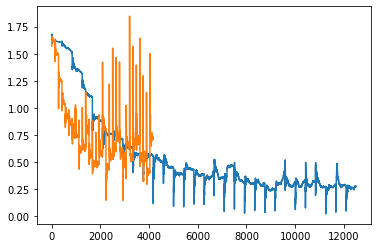

In [ ]:
# Model 1: LSTM
lstm_clf = SimpleLSTMClassifier(output_size, rnn_hidden_size=hidden_size, w2v_weights=torch.FloatTensor(word2vec_weights.vectors))
optimizer = optim.Adam(lstm_clf.parameters(), lr=LEARNING_RATE, weight_decay=0.001)


lstm_trainer = MultiClassTrainer(lstm_clf, optimizer, loss_fn, device=device, log_every_n=10)
lstm_trainer.run_training(train_sequence_loader, valid_sequence_loader, label_indexer.labels, n_epochs=30)

## Saving the models

In [ ]:
lstm_state_dict = lstm_trainer.get_model_dict()

torch.save(lstm_state_dict, "lstm_checkpoint.pt")

## Restoring the models

In [ ]:
cnn_restored_state_dict = torch.load("cnn_checkpoint.pt")

# Configure the model the exact same way
cnn_restored = TextConvolver(input_size, output_size, [3, 4, 5], channel_size=100, dropout_p=0.5, w2v_weights=torch.FloatTensor(word2vec_weights.vectors))

# Restore state dict to load the same weights again
cnn_restored.load_state_dict(cnn_restored_state_dict)

# Additional References

* Chris Olah's great article on LSTMs: https://colah.github.io/posts/2015-08-Understanding-LSTMs/
* Tips for Training Recurrent Neural Networks: https://danijar.com/tips-for-training-recurrent-neural-networks/
* The Unreasonable Effectiveness of Recurrent Neural Networks: https://karpathy.github.io/2015/05/21/rnn-effectiveness/
* Char-RNN (RNN Language Model on Characters): https://github.com/karpathy/char-rnn
* Speed up your RNN using Sequence Bucketing: https://www.kaggle.com/bminixhofer/speed-up-your-rnn-with-sequence-bucketing

## Additional(er) References (may be useful for you project)

* Attention? Attention! by Lillian Weng: https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html
